In [1]:
!pip install pyspark -q

In [2]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, count
import matplotlib.pyplot as plt

In [3]:
spark = SparkSession.builder.appName("Introducao Spark").getOrCreate()

In [4]:
link_reclamacoes = 'https://www.anatel.gov.br/dadosabertos/paineis_de_dados/consumidor/consumidor_reclamacoes.zip'

!wget https://www.anatel.gov.br/dadosabertos/paineis_de_dados/consumidor/consumidor_reclamacoes.zip

!unzip '/content/consumidor_reclamacoes.zip' -d \
'/content/'

--2024-09-18 16:35:14--  https://www.anatel.gov.br/dadosabertos/paineis_de_dados/consumidor/consumidor_reclamacoes.zip
Resolving www.anatel.gov.br (www.anatel.gov.br)... 104.18.4.215, 104.18.5.215, 2606:4700::6812:4d7, ...
Connecting to www.anatel.gov.br (www.anatel.gov.br)|104.18.4.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 536664656 (512M) [application/x-zip-compressed]
Saving to: ‘consumidor_reclamacoes.zip.2’

consumidor_reclamac 100%[===================>] 511.80M  68.8MB/s    in 9.1s    

2024-09-18 16:35:23 (56.3 MB/s) - ‘consumidor_reclamacoes.zip.2’ saved [536664656/536664656]

Archive:  /content/consumidor_reclamacoes.zip
replace /content/reclamacoes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
df_spark = spark.read.option("header","true")\
          .option("encoding", "utf-8")\
          .option("sep",";")\
          .option('inferSchema', 'true')\
          .csv('/content/reclamacoes_contexto.csv')


In [6]:
# Tipos das Colunas
df_spark.printSchema()

root
 |-- DataExtracao: date (nullable = true)
 |-- SOLICITAÇÕES: integer (nullable = true)
 |-- Ano: integer (nullable = true)
 |-- Mês: integer (nullable = true)
 |-- AnoMês: timestamp (nullable = true)
 |-- UF: string (nullable = true)
 |-- Cidade: string (nullable = true)
 |-- CO_MUNICIPIO: string (nullable = true)
 |-- CanalEntrada: string (nullable = true)
 |-- Condição: string (nullable = true)
 |-- TipoAtendimento: string (nullable = true)
 |-- Serviço: string (nullable = true)
 |-- Marca: string (nullable = true)
 |-- Assunto: string (nullable = true)
 |-- Problema: string (nullable = true)
 |-- Linha: integer (nullable = true)



In [7]:
# Vendo as 5 primeiras linhas do DF
df_spark.limit(5).show()

+------------+------------+----+---+-------------------+---+----------+------------+------------+-------------+--------------------+-------+------+--------------------+--------------------+-----+
|DataExtracao|SOLICITAÇÕES| Ano|Mês|             AnoMês| UF|    Cidade|CO_MUNICIPIO|CanalEntrada|     Condição|     TipoAtendimento|Serviço| Marca|             Assunto|            Problema|Linha|
+------------+------------+----+---+-------------------+---+----------+------------+------------+-------------+--------------------+-------+------+--------------------+--------------------+-----+
|  2018-04-23|           1|2015|  1|2015-01-01 00:00:00| DF|  Brasília|     5300108|         SIC|Reencaminhada|Pedido de Informação| Outros|Outros|       NÃO APLICÁVEL|                 SIC|    1|
|  2018-04-23|           1|2015|  1|2015-01-01 00:00:00| AC|Rio Branco|     1200401|Fale Conosco|         Nova|          Reclamação|   STFC|    OI|Bloqueio ou Suspe...|Bloqueio ou suspe...|    2|
|  2018-04-23|      

# Distribuição Temporal: Quantas reclamações foram registradas por ano? Existe uma tendência de aumento ou diminuição no número de solicitações ao longo dos anos?

In [8]:
reclamacoes_por_ano = df_spark.groupBy("Ano").agg(count("SOLICITAÇÕES").alias("total_reclamacoes")).orderBy("Ano")
reclamacoes_por_ano.show()

+----+-----------------+
| Ano|total_reclamacoes|
+----+-----------------+
|2015|          3434077|
|2016|          3364179|
|2017|          2953594|
|2018|          2590318|
|2019|          2617122|
|2020|          2351831|
|2021|          1866754|
|2022|          1502909|
|2023|          1173279|
|2024|           750454|
+----+-----------------+



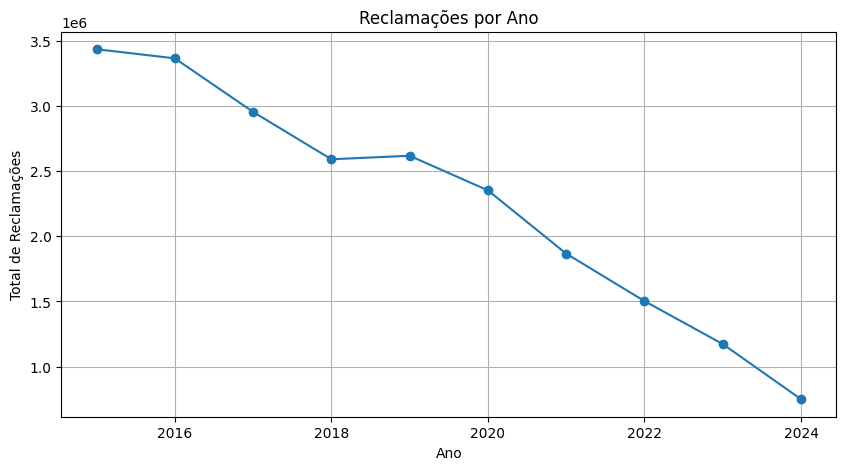

In [9]:
# Conversão para Pandas
reclamacoes_por_ano_pd = reclamacoes_por_ano.toPandas()

# Plotando
plt.figure(figsize=(10, 5))
plt.plot(reclamacoes_por_ano_pd['Ano'], reclamacoes_por_ano_pd['total_reclamacoes'], marker='o')
plt.title('Reclamações por Ano')
plt.xlabel('Ano')
plt.ylabel('Total de Reclamações')
plt.grid()
plt.show()


# Reclamações por Região: Qual é o estado (UF) com o maior número de reclamações? Como os diferentes estados se comparam em relação ao volume de solicitações?

In [10]:
reclamacoes_por_estado = df_spark.groupBy("UF").agg(count("SOLICITAÇÕES").alias("total_reclamacoes")).orderBy(col("total_reclamacoes").desc())
reclamacoes_por_estado.show()

+---+-----------------+
| UF|total_reclamacoes|
+---+-----------------+
| SP|          6712704|
| MG|          3156539|
| RJ|          2977069|
| BA|          1411551|
| PR|          1268895|
| RS|          1126379|
| GO|           799965|
| SC|           771828|
| PE|           704172|
| CE|           568071|
| DF|           548162|
| ES|           391000|
| PA|           314124|
| PB|           229234|
| MA|           220584|
| SE|           191623|
| MS|           188061|
| MT|           184366|
| RN|           171556|
| AM|           167079|
+---+-----------------+
only showing top 20 rows



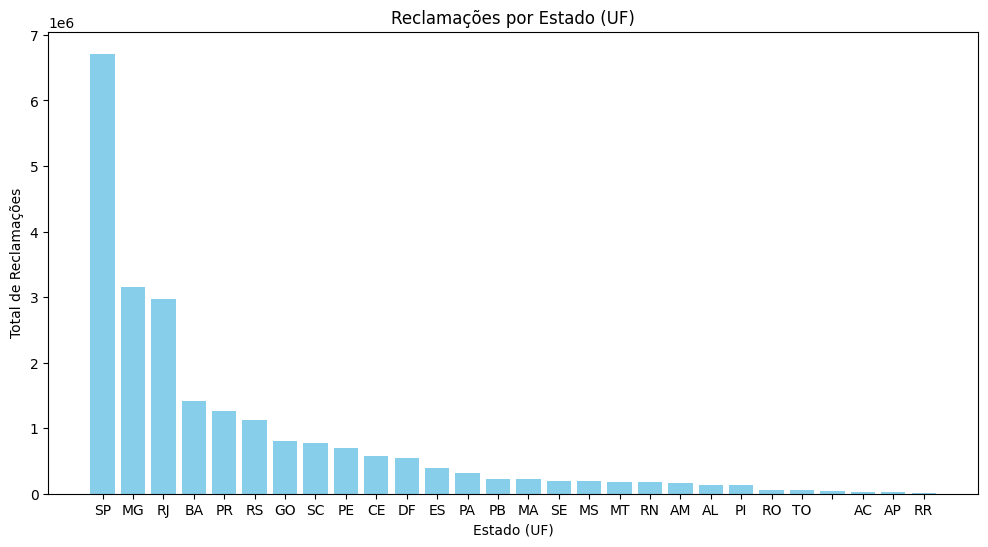

In [11]:
# Filtrando valores nulos
reclamacoes_por_estado_filtered = reclamacoes_por_estado.na.drop()

# Convertendo para Pandas
reclamacoes_por_estado_pd = reclamacoes_por_estado_filtered.toPandas()

# Plotando
plt.figure(figsize=(12, 6))
plt.bar(reclamacoes_por_estado_pd['UF'], reclamacoes_por_estado_pd['total_reclamacoes'], color='skyblue')
plt.title('Reclamações por Estado (UF)')
plt.xlabel('Estado (UF)')
plt.ylabel('Total de Reclamações')
plt.xticks(rotation=0)
plt.show()


# Análise por Canal de Entrada: Qual o canal de entrada mais utilizado pelos usuários para registrar suas reclamações? Há alguma diferença no tipo de problema relatado dependendo do canal de entrada?

In [12]:
canal_entrada = df_spark.groupBy("CanalEntrada").agg(count("SOLICITAÇÕES").alias("total_reclamacoes")).orderBy(col("total_reclamacoes").desc())
canal_entrada.show()

# Diferença de problemas por canal
problemas_por_canal = df_spark.groupBy("CanalEntrada", "Problema").agg(count("SOLICITAÇÕES").alias("total_reclamacoes"))
problemas_por_canal.show()

+-------------------+-----------------+
|       CanalEntrada|total_reclamacoes|
+-------------------+-----------------+
|        Call Center|         11644584|
|       Fale Conosco|          4520508|
|        Usuário WEB|          2981335|
|         Mobile App|          2165991|
|   Aplicativo Móvel|          1211841|
|Atendimento Pessoal|            63081|
|                SEI|             8472|
|    Correspondência|             4009|
|                SIC|             3507|
|                Fax|              755|
|             E-mail|              264|
|                TTS|              154|
|                SOA|               16|
+-------------------+-----------------+

+-------------------+--------------------+-----------------+
|       CanalEntrada|            Problema|total_reclamacoes|
+-------------------+--------------------+-----------------+
|       Fale Conosco|          Legislação|              263|
|    Correspondência|Rádio Pirata / Cl...|               25|
|    Correspon

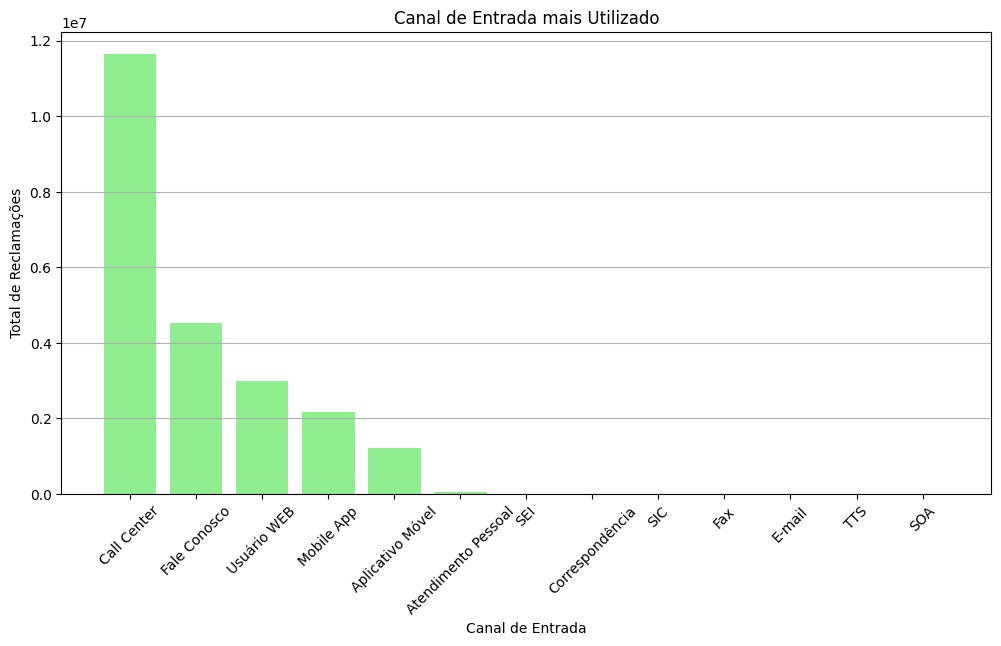

In [13]:
canal_entrada_pd = canal_entrada.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(canal_entrada_pd['CanalEntrada'], canal_entrada_pd['total_reclamacoes'], color='lightgreen')
plt.title('Canal de Entrada mais Utilizado')
plt.xlabel('Canal de Entrada')
plt.ylabel('Total de Reclamações')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


# Análise de Problemas e Assuntos: Quais são os problemas e assuntos mais comuns relatados pelos usuários? Existe algum padrão ou concentração de reclamações em um determinado serviço ou marca?

In [14]:
problemas_comuns = df_spark.groupBy("Problema").agg(count("SOLICITAÇÕES").alias("total_reclamacoes")).orderBy(col("total_reclamacoes").desc())
problemas_comuns.show()


+--------------------+-----------------+
|            Problema|total_reclamacoes|
+--------------------+-----------------+
|Cobrança em desac...|          1999065|
|Cobrança após can...|          1061733|
|Cobrança de servi...|           800315|
|Bloqueio ou suspe...|           650245|
|Cobrança indevida...|           586282|
|Cancelamento soli...|           558498|
|Linha muda ou sem...|           549268|
|Cancelamento inde...|           512123|
|Sem Conexão de dados|           472546|
|Lentidão ou veloc...|           467661|
|Não cumprimento d...|           447785|
|Instalação ou hab...|           447144|
|Não consegue alte...|           369599|
|Cobrança de valor...|           348859|
|Cobrança de servi...|           337801|
|Ressarcimento de ...|           331472|
|Cobrança de servi...|           327684|
|Reparo não realiz...|           290615|
|Persistência do p...|           289094|
|Consumidor não co...|           274573|
+--------------------+-----------------+
only showing top

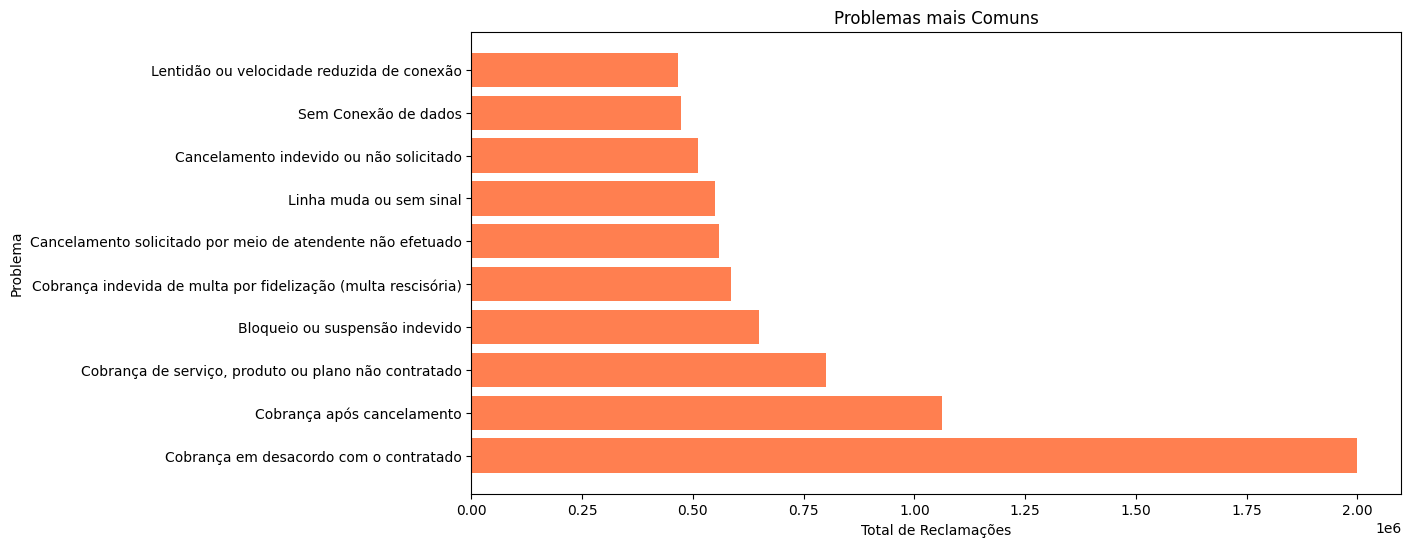

In [15]:
problemas_comuns_pd = problemas_comuns.limit(10).toPandas()

plt.figure(figsize=(12, 6))
plt.barh(problemas_comuns_pd['Problema'], problemas_comuns_pd['total_reclamacoes'], color='coral')
plt.title('Problemas mais Comuns')
plt.xlabel('Total de Reclamações')
plt.ylabel('Problema')
plt.show()


# Reclamações por Tipo de Atendimento: Quais tipos de atendimento são mais solicitados? Há algum tipo de atendimento que é mais eficaz, resultando em menos solicitações subsequentes?

In [16]:
atendimentos_comuns = df_spark.groupBy("TipoAtendimento").agg(count("SOLICITAÇÕES").alias("total_reclamacoes")).orderBy(col("total_reclamacoes").desc())
atendimentos_comuns.show()

+--------------------+-----------------+
|     TipoAtendimento|total_reclamacoes|
+--------------------+-----------------+
|          Reclamação|         22213402|
|Pedido de Informação|           313904|
|            Denúncia|            33118|
|    Denúncia Anônima|            17978|
|Outras Manifestações|            12388|
|              Elogio|             7351|
|            Sugestão|             6066|
|    Denúncia ANÔNIMA|              310|
+--------------------+-----------------+



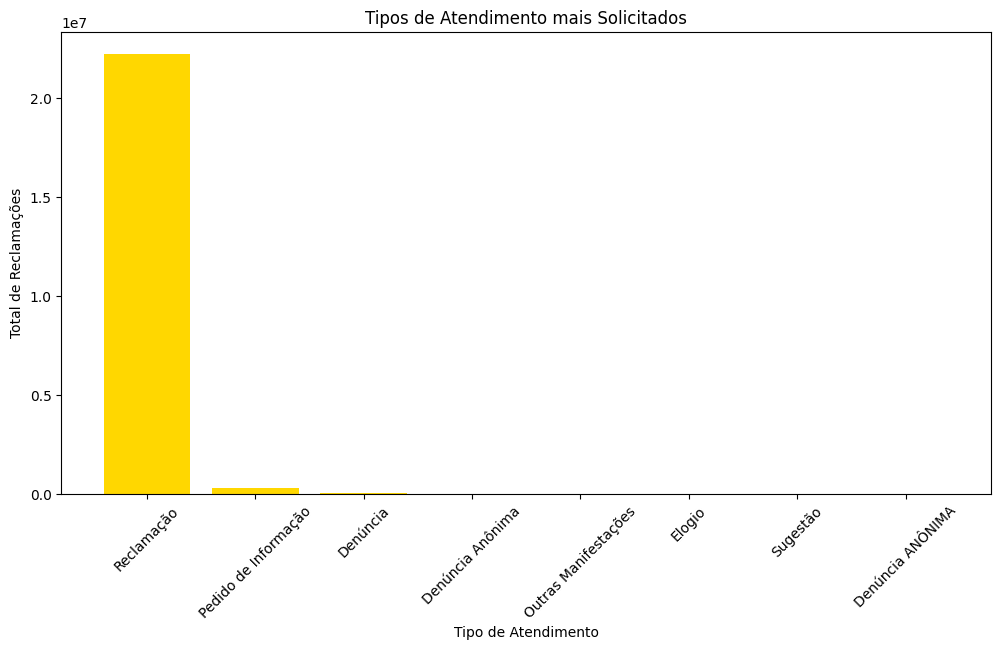

In [17]:
atendimentos_comuns_pd = atendimentos_comuns.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(atendimentos_comuns_pd['TipoAtendimento'], atendimentos_comuns_pd['total_reclamacoes'], color='gold')
plt.title('Tipos de Atendimento mais Solicitados')
plt.xlabel('Tipo de Atendimento')
plt.ylabel('Total de Reclamações')
plt.xticks(rotation=45)
plt.show()


# Análise de Cidade e Serviço: Quais são as cidades com o maior número de reclamações por serviço? Existe alguma cidade que se destaque de forma positiva ou negativa em relação ao atendimento prestado?

In [18]:
reclamacoes_por_cidade_servico = df_spark.groupBy("Cidade", "Serviço").agg(count("SOLICITAÇÕES").alias("total_reclamacoes")).orderBy(col("total_reclamacoes").desc())
reclamacoes_por_cidade_servico.show()


+--------------+-------+-----------------+
|        Cidade|Serviço|total_reclamacoes|
+--------------+-------+-----------------+
|     São Paulo|SMP_Pós|           664181|
|Rio de Janeiro|SMP_Pós|           446883|
|     São Paulo|    SCM|           390209|
|     São Paulo|   STFC|           294949|
|Belo Horizonte|SMP_Pós|           290966|
|     São Paulo|SMP_Pré|           285046|
|Rio de Janeiro|    SCM|           276051|
|Rio de Janeiro|   STFC|           271475|
|     São Paulo|   SeAC|           260511|
|      Salvador|SMP_Pós|           195919|
|Rio de Janeiro|   SeAC|           192903|
|      Brasília|SMP_Pós|           191814|
|Belo Horizonte|    SCM|           163188|
|Belo Horizonte|   STFC|           149629|
|      Curitiba|SMP_Pós|           145210|
|      Salvador|SMP_Pré|           142414|
|Rio de Janeiro|SMP_Pré|           137709|
|       Goiânia|SMP_Pós|           128983|
|      Salvador|    SCM|           127417|
|      Salvador|   STFC|           125644|
+----------

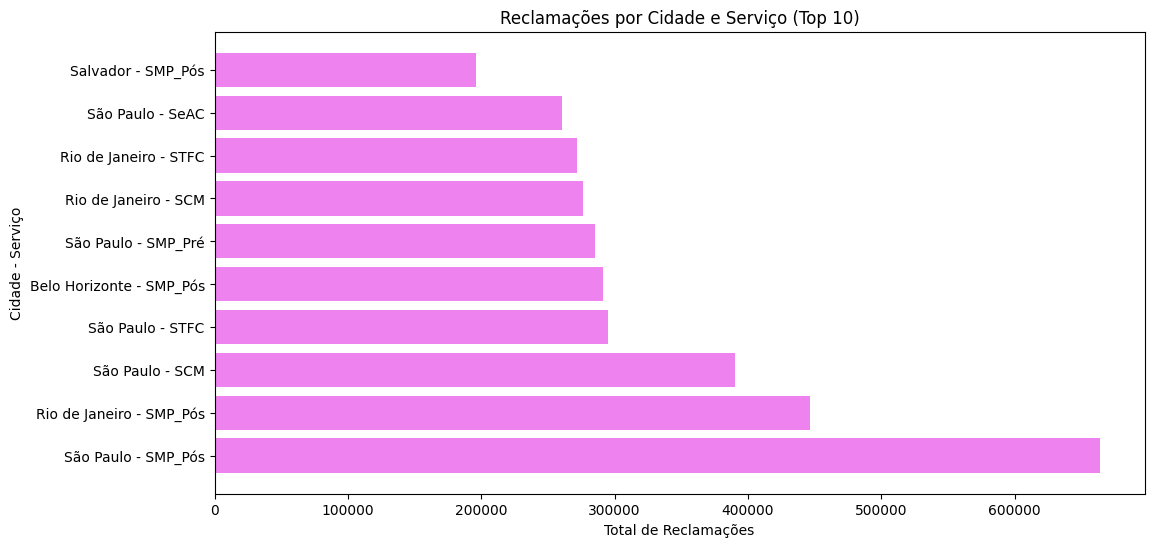

In [19]:
reclamacoes_por_cidade_servico_pd = reclamacoes_por_cidade_servico.limit(10).toPandas()  # Limitando para evitar gráfico muito cheio

plt.figure(figsize=(12, 6))
plt.barh(reclamacoes_por_cidade_servico_pd['Cidade'] + ' - ' + reclamacoes_por_cidade_servico_pd['Serviço'],
        reclamacoes_por_cidade_servico_pd['total_reclamacoes'], color='violet')
plt.title('Reclamações por Cidade e Serviço (Top 10)')
plt.xlabel('Total de Reclamações')
plt.ylabel('Cidade - Serviço')
plt.show()


# Evolução Mensal das Reclamações: Como as reclamações evoluem ao longo dos meses dentro de um mesmo ano? Existe algum período específico em que as reclamações aumentam significativamente?

In [20]:
evolucao_mensal = df_spark.groupBy("Ano", "Mês").agg(count("SOLICITAÇÕES").alias("total_reclamacoes")).orderBy("Ano", "Mês")
evolucao_mensal.show()


+----+---+-----------------+
| Ano|Mês|total_reclamacoes|
+----+---+-----------------+
|2015|  1|           180864|
|2015|  2|           221442|
|2015|  3|           310641|
|2015|  4|           282299|
|2015|  5|           297530|
|2015|  6|           304400|
|2015|  7|           342906|
|2015|  8|           316767|
|2015|  9|           305484|
|2015| 10|           294596|
|2015| 11|           287916|
|2015| 12|           289232|
|2016|  1|           304171|
|2016|  2|           293737|
|2016|  3|           328335|
|2016|  4|           278452|
|2016|  5|           272804|
|2016|  6|           278217|
|2016|  7|           274271|
|2016|  8|           297730|
+----+---+-----------------+
only showing top 20 rows



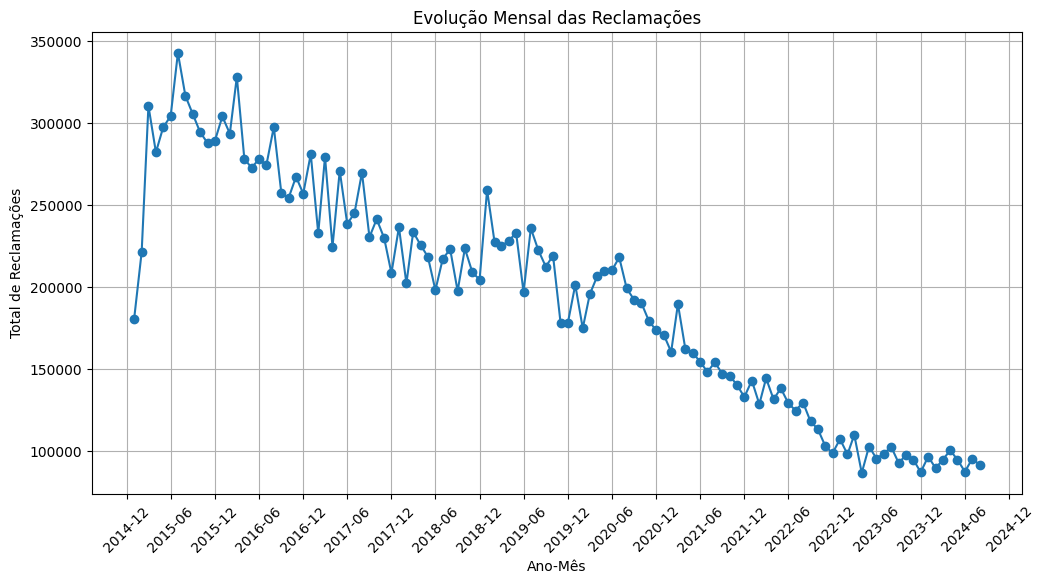

In [21]:
import matplotlib.dates as mdates

evolucao_mensal_pd = evolucao_mensal.toPandas()

# Criando a coluna 'Ano-Mês' como uma data
evolucao_mensal_pd['Ano-Mês'] = pd.to_datetime(evolucao_mensal_pd['Ano'].astype(str) + '-' + evolucao_mensal_pd['Mês'].astype(str))

plt.figure(figsize=(12, 6))
plt.plot(evolucao_mensal_pd['Ano-Mês'], evolucao_mensal_pd['total_reclamacoes'], marker='o')
plt.title('Evolução Mensal das Reclamações')
plt.xlabel('Ano-Mês')
plt.ylabel('Total de Reclamações')

# Formatando os ticks do eixo x
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Ticks a cada 6 meses
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formato de data

plt.xticks(rotation=45)
plt.grid()
plt.show()
